In [1]:
import sys,os,glob,copy
sys.path.append('../')
import numpy as np
from numpy.linalg import norm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d, griddata
from itertools import product
import matplotlib as mpl
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
import glob
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')


pd.set_option('display.max_rows', 200)

### Load Recast Data

In [2]:
recastDataAxial = pd.read_pickle('../scanResults_axial.pcl')
recastDataVector = pd.read_pickle('../scanResults_vector.pcl')

The efficiency for the $i$-th bin, $\epsilon_{i}$, is given by:

$$ \epsilon_{i} = \frac{n^{i}_{s}}{\sigma_{T}\mathcal{L}},   $$
where $n^{i}_{s}$ is the number of events in the correspondent bin, $\sigma_{T}$ is the total cross-section, and $\mathcal{L}$ is the integrated luminosity.  

### Obtain efficiencies

In [4]:
def getBins(dfModel,rightBin = 2000.):
    
    bins = {c : eval(c.split('_')[1]) for c in dfModel.columns if ("bin_" in c and not 'Error' in c)}
    binsError = {c : eval(c.split('_')[1]) for c in dfModel.columns if ("bin_" in c and 'ErrorPlus' in c)}    
    binCenter = (np.array(list(bins.values()))+np.diff(list(bins.values())+[rightBin])/2).tolist()    
    binLeft = [bins[c] for c in bins]+[rightBin] 
    
    return bins,binsError,binCenter,binLeft

bins, binsError, binCenter, binLeft = getBins(recastDataAxial)

def getEfficiencies(dfSingle, bins):
    
    xsec = dfSingle['Total xsec (pb)'].iloc[0]
    lumi = dfSingle['Luminosity (1/fb)'].iloc[0]
    eff = {c : dfSingle[c].iloc[0]/(xsec*lumi) for c in bins}
    
    return eff

In [5]:
effA = getEfficiencies(recastDataAxial, bins)
effV = getEfficiencies(recastDataVector, bins)

### Plot Efficiencies

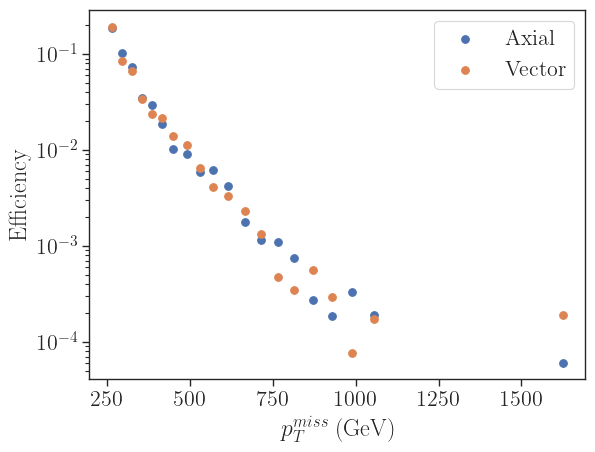

In [8]:
plt.scatter(x=binCenter, y=effA.values(), s=30, label='Axial')
plt.scatter(x=binCenter, y=effV.values(), s=30, label='Vector')

plt.xlabel(r'$p_{T}^{miss}$ (GeV)')

plt.ylabel('Efficiency')
plt.yscale('log')

plt.legend()
plt.show()